## 1. Setup and Imports

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_fetcher import BreezeDataFetcher
from regime_classifier import RegimeClassifier
from multi_timeframe_analyzer import MultiTimeframeRegimeAnalyzer
from utils import (
    plot_regime_matrix,
    plot_price_with_regimes,
    get_regime_statistics,
    export_regime_report
)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful!")

✓ All imports successful!


## 2A. Sample Data (Skip if using 2B)

In [2]:
# from sample_data_generator import generate_sample_stock_data

# # Generate sample data for testing
# STOCK_CODE = "RELIANCE"
# START_DATE = "2023-01-01"
# END_DATE = "2024-12-15"

# print(f"Generating sample data for {STOCK_CODE} from {START_DATE} to {END_DATE}...")
# df = generate_sample_stock_data(
#     start_date=START_DATE,
#     end_date=END_DATE,
#     initial_price=2500.0,
#     stock_name=STOCK_CODE
# )

# print(f"\n✓ Sample data generated successfully!")
# print(f"Shape: {df.shape}")
# print(f"\nFirst few rows:")
# df.head()

## 2B. Data using API (Skip if using 2A)


In [3]:
# Initialize data fetcher
fetcher = BreezeDataFetcher()

# Configuration
STOCK_CODE = "TCS"
# Change this to any NSE stock
EXCHANGE = "NSE"
START_DATE = "2020-01-01"
END_DATE = "2025-12-16"

print(f"Fetching data for {STOCK_CODE} from {START_DATE} to {END_DATE}...")

# Fetch historical data
df = fetcher.fetch_historical_data(
    stock_code=STOCK_CODE,
    exchange=EXCHANGE,
    start_date=START_DATE,
    end_date=END_DATE,
    interval="1day"
)

print(f"\n✓ Data fetched successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nLast few rows:")
print(df.tail())

Fetching data for TCS from 2020-01-01 to 2025-12-16...

✓ Data fetched successfully!
Shape: (1481, 14)

First few rows:
             datetime stock_code exchange_code product_type expiry_date right  \
0 2020-01-01 12:01:00        TCS           NSE         None        None  None   
1 2020-01-02 12:01:00        TCS           NSE         None        None  None   
2 2020-01-03 12:01:00        TCS           NSE         None        None  None   
3 2020-01-06 12:01:00        TCS           NSE         None        None  None   
4 2020-01-07 12:01:00        TCS           NSE         None        None  None   

  strike_price     open     high     low    close   volume open_interest  \
0         None  2168.00  2183.90  2154.0  2167.60  1354908          None   
1         None  2179.95  2179.95  2149.2  2157.65  2380752          None   
2         None  2164.00  2223.00  2164.0  2200.65  4655761          None   
3         None  2205.00  2225.95  2187.9  2200.45  3023209          None   
4         Non

In [4]:
# Basic data info
print("Data Summary:")
print(f"Date Range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Total Trading Days: {len(df)}")
print(f"\nPrice Statistics:")
df[['open', 'high', 'low', 'close', 'volume']].describe()

Data Summary:
Date Range: 2020-01-01 12:01:00 to 2025-12-15 12:12:00
Total Trading Days: 1481

Price Statistics:


,open,high,low,close,volume
count,1481.000000,1481.000000,1481.000000,1481.000000,1.481000e+03
mean,3312.911614,3343.859453,3281.247637,3311.715665,2.688471e+06
std,605.880507,607.871823,603.404783,605.600081,1.616332e+06
min,1559.700000,1685.450000,1506.050000,1636.350000,6.505700e+04
25%,3097.000000,3123.500000,3060.900000,3095.700000,1.688475e+06
50%,3350.000000,3375.950000,3321.450000,3344.200000,2.280996e+06
75%,3706.000000,3739.000000,3672.000000,3696.400000,3.165495e+06
max,4576.000000,4592.250000,4512.000000,4553.750000,1.983983e+07


## 3. Daily Regime Analysis

In [5]:
# Initialize classifier
classifier = RegimeClassifier(
    reference_window=30,  # 30 days reference period
    focus_window=90,      # 90 days focus period
    volatility_thresholds=(-0.5, 0.5),
    direction_thresholds=(-0.5, 0.5)
)

print("Performing daily regime analysis...")
daily_regimes = classifier.classify_full_timeseries(df, step_size=30)

print(f"\n✓ Analysis complete!")
print(f"Total periods analyzed: {len(daily_regimes)}")
print(f"\nFirst few regime classifications:")
daily_regimes.head()

Performing daily regime analysis...

✓ Analysis complete!
Total periods analyzed: 46

First few regime classifications:


,start_date,end_date,volatility_regime,direction_regime,volatility_z_score,direction_z_score,focus_volatility,focus_direction,ref_volatility,ref_direction
0,2020-02-11 12:02:00,2020-06-25 12:06:00,High,Rising,2.133179,2.146875,0.030266,0.225719,0.015373,-3.073626
1,2020-03-26 12:03:00,2020-08-06 12:08:00,Low,Rising,-0.723890,2.598134,0.023964,6.295607,0.037097,-21.050823
2,2020-05-14 12:05:00,2020-09-17 12:09:00,Low,Falling,-1.429639,-0.767848,0.015946,4.817277,0.033588,7.819288
3,2020-06-26 12:06:00,2020-10-30 12:10:00,Medium,Rising,0.138272,1.450314,0.017621,7.051920,0.016561,4.087697
4,2020-08-07 12:08:00,2020-12-14 12:12:00,Medium,Rising,-0.129949,0.810194,0.016353,6.697547,0.017111,4.766607



Daily Regime Distribution Matrix:
volatility_regime  Low  Medium  High  All
direction_regime                         
Falling              4       9     6   19
Sideways             0       1     1    2
Rising               6      12     7   25
All                 10      22    14   46


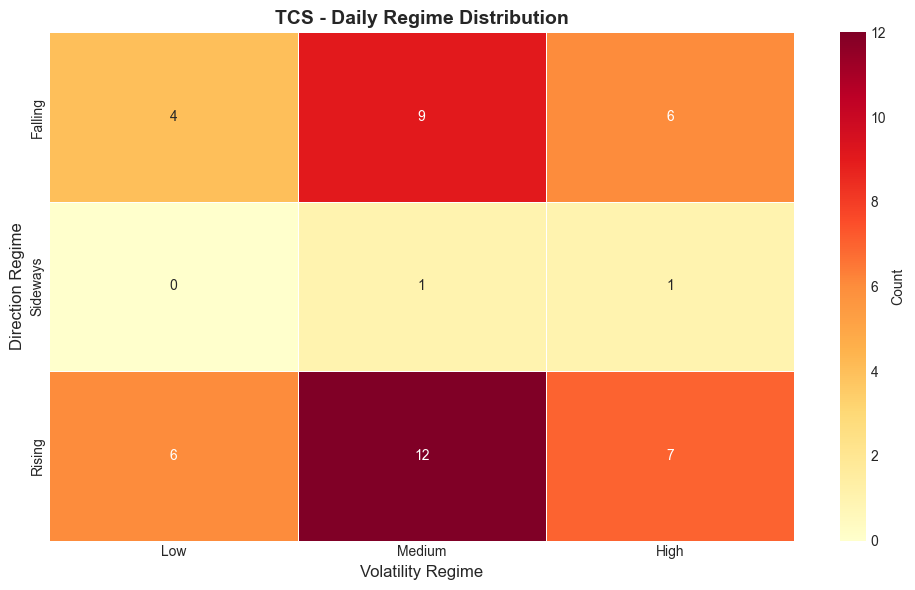

In [6]:
# Create regime distribution matrix
daily_matrix = classifier.create_regime_matrix(daily_regimes)
print("\nDaily Regime Distribution Matrix:")
print(daily_matrix)

# Plot matrix
plot_regime_matrix(daily_matrix, title=f"{STOCK_CODE} - Daily Regime Distribution")

In [7]:
# Get statistics
daily_stats = get_regime_statistics(daily_regimes)
print("\nDaily Regime Statistics:")
for key, value in daily_stats.items():
    print(f"{key}: {value}")


Daily Regime Statistics:
total_periods: 46
volatility_distribution: {'Medium': 22, 'High': 14, 'Low': 10}
direction_distribution: {'Rising': 25, 'Falling': 19, 'Sideways': 2}
avg_volatility_z_score: 0.2103549135835688
avg_direction_z_score: 0.41583622483997873
most_common_regime: Rising + Medium


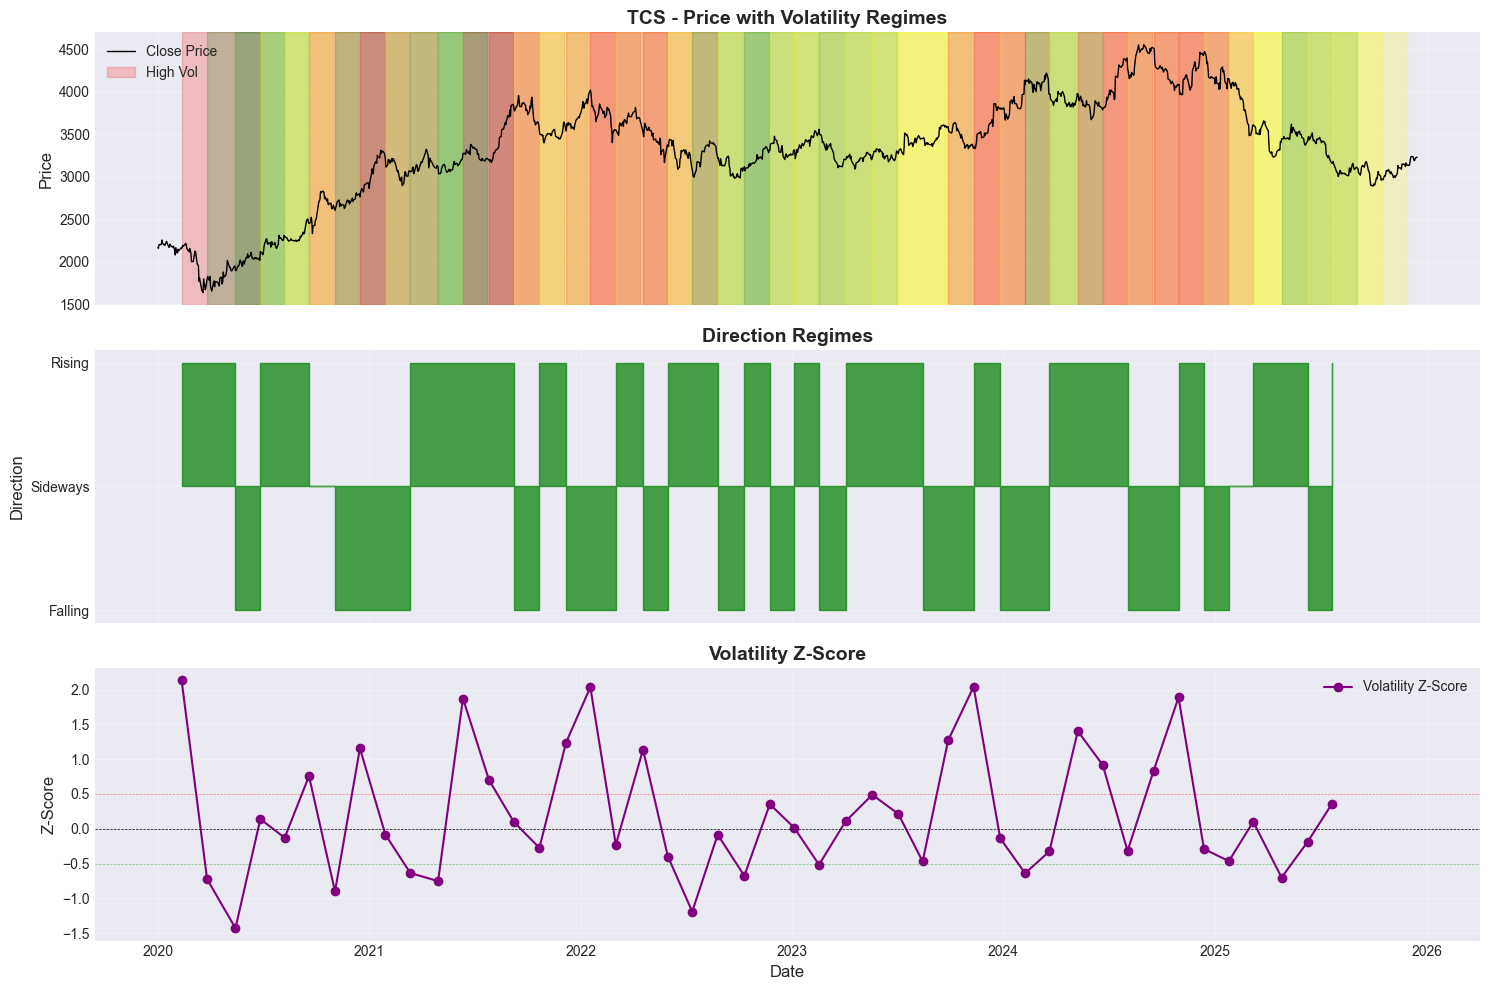

In [8]:
# Visualize price with regimes
plot_price_with_regimes(df, daily_regimes, stock_name=STOCK_CODE)

## 4. Multi-Timeframe Analysis (Daily, Weekly, Monthly)

In [9]:
# Initialize multi-timeframe analyzer
mtf_analyzer = MultiTimeframeRegimeAnalyzer(
    reference_window=30,
    focus_window=90,
    volatility_thresholds=(-0.5, 0.5),
    direction_thresholds=(-0.5, 0.5)
)

print("Performing multi-timeframe analysis...")
print("This may take a moment...\n")

# Analyze all timeframes
all_regimes = mtf_analyzer.analyze_all_timeframes(df, step_size=30)

print("\n✓ Multi-timeframe analysis complete!")

Performing multi-timeframe analysis...
This may take a moment...

Analyzing Daily regimes...
Analyzing Weekly regimes...
Weekly data points: 312
Weekly regimes identified: 74
Analyzing Monthly regimes...
Monthly data points: 72
Monthly regimes identified: 69

✓ Multi-timeframe analysis complete!



DAILY REGIME ANALYSIS
Total periods: 46

Regime Distribution:
volatility_regime  Low  Medium  High  All
direction_regime                         
Falling              4       9     6   19
Sideways             0       1     1    2
Rising               6      12     7   25
All                 10      22    14   46


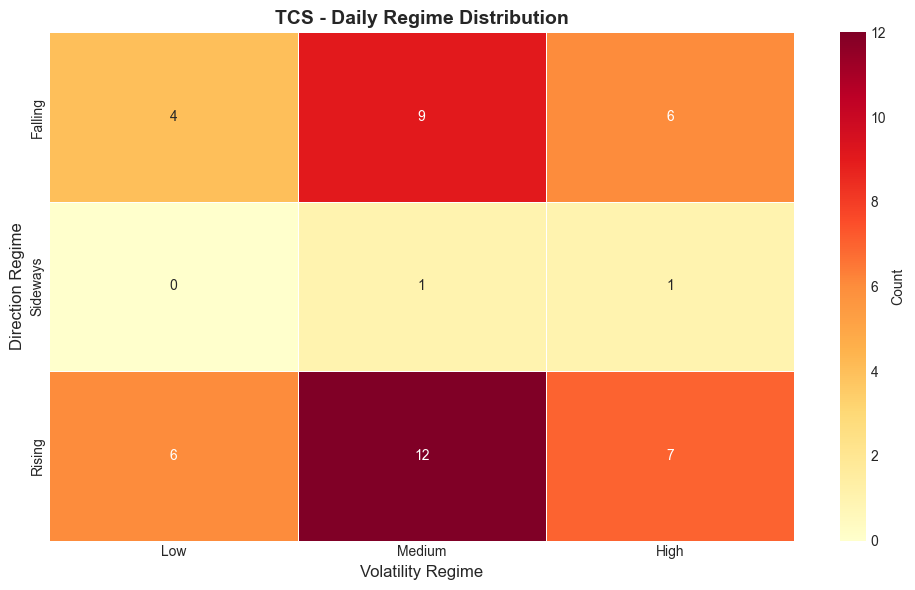


WEEKLY REGIME ANALYSIS
Total periods: 74

Regime Distribution:
volatility_regime  Low  Medium  High  All
direction_regime                         
Falling              0      33     0   33
Sideways             0       7     0    7
Rising               0      34     0   34
All                  0      74     0   74


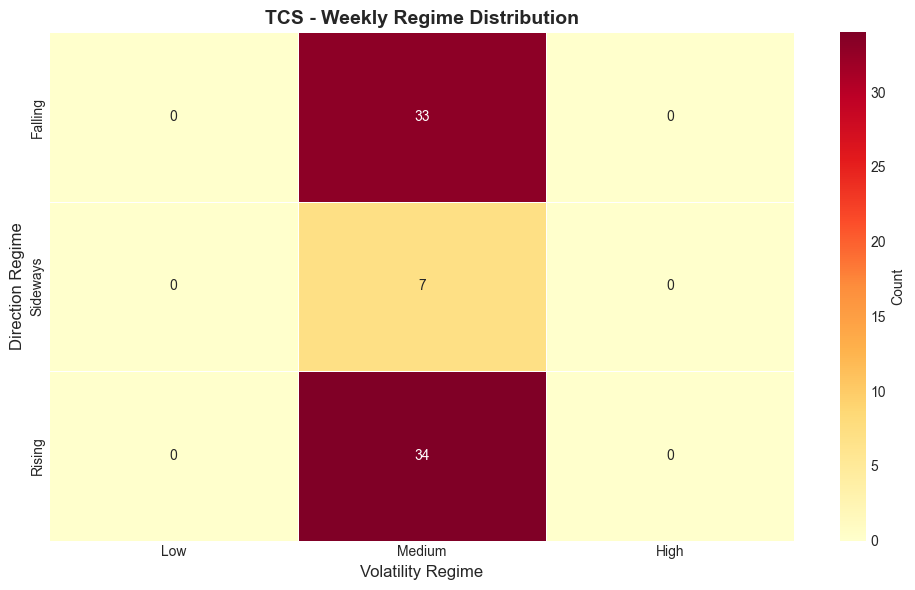


MONTHLY REGIME ANALYSIS
Total periods: 69

Regime Distribution:
volatility_regime  Low  Medium  High  All
direction_regime                         
Falling              0       0     0    0
Sideways             0      69     0   69
Rising               0       0     0    0
All                  0      69     0   69


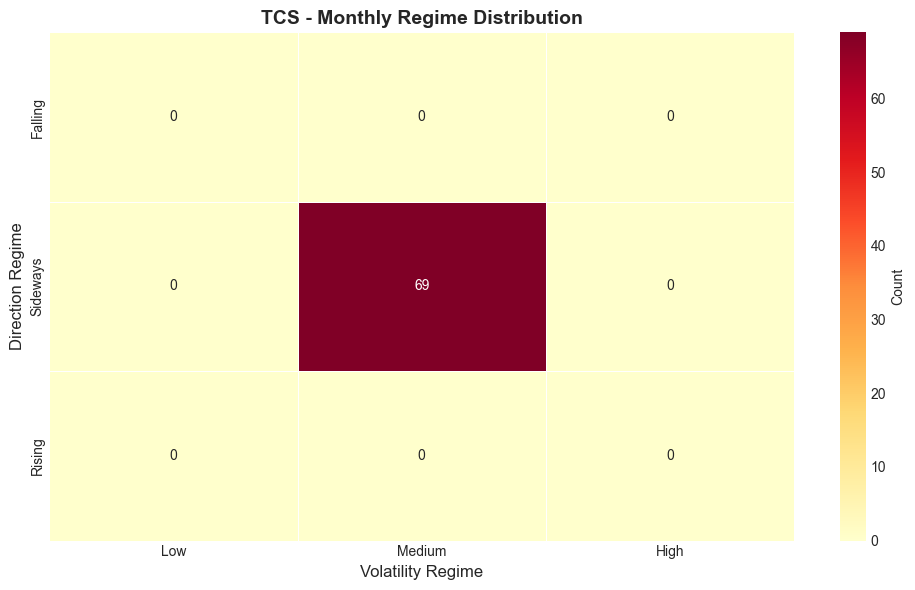

In [10]:
# Display results for each timeframe
for timeframe, regimes_df in all_regimes.items():
    print(f"\n{'='*60}")
    print(f"{timeframe.upper()} REGIME ANALYSIS")
    print(f"{'='*60}")
    print(f"Total periods: {len(regimes_df)}")
    
    # Create matrix
    matrix = classifier.create_regime_matrix(regimes_df)
    print(f"\nRegime Distribution:")
    print(matrix)
    
    # Plot matrix
    plot_regime_matrix(matrix, title=f"{STOCK_CODE} - {timeframe.capitalize()} Regime Distribution")

## 5. Compare Current Regimes Across Timeframes

Analyzing Daily regimes...
Analyzing Weekly regimes...
Weekly data points: 312
Weekly regimes identified: 74
Analyzing Monthly regimes...
Monthly data points: 72
Monthly regimes identified: 69

Current Market Regime for TCS:


,timeframe,volatility_regime,direction_regime,start_date,end_date
0,Daily,Medium,Rising,2025-07-21 12:07:00,2025-11-28 12:11:00
1,Weekly,Medium,Sideways,2025-09-21 00:00:00,2025-12-14 00:00:00
2,Monthly,Medium,Sideways,2025-10-31 00:00:00,2025-12-31 00:00:00


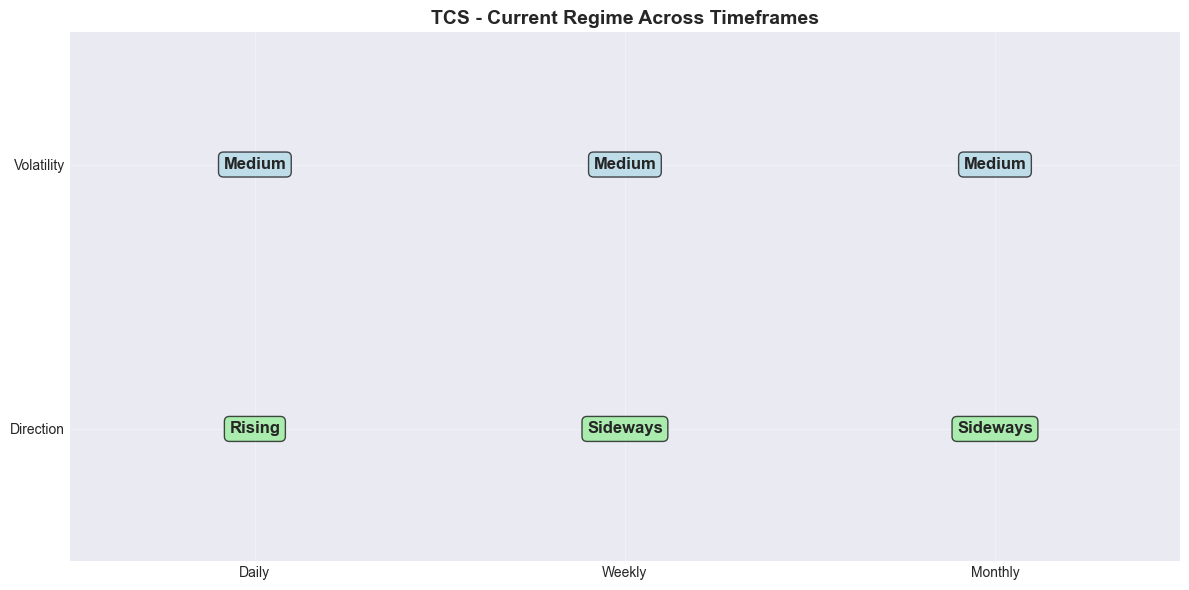

In [11]:
# Get current regime comparison
current_regimes = mtf_analyzer.compare_timeframes(df)

print(f"\nCurrent Market Regime for {STOCK_CODE}:")
print("="*70)
display(current_regimes)

# Visual representation
fig, ax = plt.subplots(figsize=(12, 6))

timeframes = current_regimes['timeframe'].values
volatility = current_regimes['volatility_regime'].values
direction = current_regimes['direction_regime'].values

x = np.arange(len(timeframes))
width = 0.35

# Create labels
vol_labels = [f"{v}" for v in volatility]
dir_labels = [f"{d}" for d in direction]

# Plot
for i, (tf, vol, dir) in enumerate(zip(timeframes, vol_labels, dir_labels)):
    ax.text(i, 1, vol, ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    ax.text(i, 0, dir, ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

ax.set_ylim(-0.5, 1.5)
ax.set_xlim(-0.5, len(timeframes) - 0.5)
ax.set_xticks(x)
ax.set_xticklabels(timeframes)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Direction', 'Volatility'])
ax.set_title(f'{STOCK_CODE} - Current Regime Across Timeframes', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Analyze Multiple Stocks

In [12]:
# Analyze multiple stocks
STOCKS = ["HDFWA2", "TCS", "NHPC","BHAAIR", "KOTMNC"]

multi_stock_results = {}

for stock in STOCKS:
    try:
        print(f"\nAnalyzing {stock}...")
        
        # Fetch data
        stock_df = fetcher.fetch_historical_data(
            stock_code=stock,
            exchange="NSE",
            start_date=START_DATE,
            end_date=END_DATE
        )
        
        # Get current regime
        current = mtf_analyzer.get_current_regime(stock_df, 'daily')
        
        if current:
            multi_stock_results[stock] = {
                'Volatility': current['volatility_regime'],
                'Direction': current['direction_regime'],
                'Vol Z-Score': round(current['volatility_z_score'], 2),
                'Dir Z-Score': round(current['direction_z_score'], 2)
            }
    
    except Exception as e:
        print(f"Error analyzing {stock}: {e}")
        continue

# Display results
print("\n" + "="*80)
print("MULTI-STOCK REGIME COMPARISON (Daily)")
print("="*80)
comparison_df = pd.DataFrame(multi_stock_results).T
display(comparison_df)


Analyzing HDFWA2...
Analyzing Daily regimes...

Analyzing TCS...
Analyzing Daily regimes...

Analyzing NHPC...
Analyzing Daily regimes...

Analyzing BHAAIR...
Analyzing Daily regimes...

Analyzing KOTMNC...
Analyzing Daily regimes...

MULTI-STOCK REGIME COMPARISON (Daily)


,Volatility,Direction,Vol Z-Score,Dir Z-Score
HDFWA2,Low,Falling,-0.68,-1.93
TCS,Medium,Rising,0.36,1.96
NHPC,Medium,Falling,-0.28,-2.61
BHAAIR,Medium,Falling,-0.13,-0.64
KOTMNC,Medium,Falling,0.1,-0.65


## 7. Export Results

In [13]:
# Export regime analysis report
output_dir = "../data/reports"
os.makedirs(output_dir, exist_ok=True)

# Export daily analysis
output_path = os.path.join(output_dir, f"{STOCK_CODE}_regime_report.txt")
export_regime_report(
    daily_regimes,
    daily_matrix,
    output_path,
    stock_name=STOCK_CODE
)

# Export detailed regime data
for timeframe, regimes_df in all_regimes.items():
    csv_path = os.path.join(output_dir, f"{STOCK_CODE}_{timeframe}_regimes.csv")
    regimes_df.to_csv(csv_path, index=False)
    print(f"✓ Exported {timeframe} data to {csv_path}")

print("\n✓ All results exported successfully!")

Report exported to ../data/reports\TCS_regime_report.txt
✓ Exported daily data to ../data/reports\TCS_daily_regimes.csv
✓ Exported weekly data to ../data/reports\TCS_weekly_regimes.csv
✓ Exported monthly data to ../data/reports\TCS_monthly_regimes.csv

✓ All results exported successfully!


## 8. Key Insights Summary

In [14]:
print(f"\n{'='*80}")
print(f"REGIME IDENTIFICATION SUMMARY - {STOCK_CODE}")
print(f"{'='*80}")

print(f"\n Analysis Period: {START_DATE} to {END_DATE}")
print(f" Total Trading Days: {len(df)}")

print(f"\n CURRENT MARKET REGIME:")
for _, row in current_regimes.iterrows():
    print(f"  {row['timeframe']:10} → Volatility: {row['volatility_regime']:8} | Direction: {row['direction_regime']:8}")

print(f"\n MOST COMMON REGIMES (Daily):")
vol_dist = daily_regimes['volatility_regime'].value_counts()
dir_dist = daily_regimes['direction_regime'].value_counts()
print(f"  Volatility: {vol_dist.index[0]} ({vol_dist.values[0]} periods)")
print(f"  Direction:  {dir_dist.index[0]} ({dir_dist.values[0]} periods)")

print(f"\n{'='*80}")
print("✓ Analysis Complete!")
print(f"{'='*80}")


REGIME IDENTIFICATION SUMMARY - TCS

 Analysis Period: 2020-01-01 to 2025-12-16
 Total Trading Days: 1481

 CURRENT MARKET REGIME:
  Daily      → Volatility: Medium   | Direction: Rising  
  Weekly     → Volatility: Medium   | Direction: Sideways
  Monthly    → Volatility: Medium   | Direction: Sideways

 MOST COMMON REGIMES (Daily):
  Volatility: Medium (22 periods)
  Direction:  Rising (25 periods)

✓ Analysis Complete!
